In [20]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt 

#### Load merged events 

In [22]:
events = pd.read_csv("merged_events.csv")

In [23]:
events.head(2)

,id,siteId,equipmentId,eventType,measured_rate,measured_duration,measured_quantity,measured_startTime,measured_endTime,calculated_duration,calculated_quantity,calculated_startTime,calculated_endTime
0,e71e4e06-1940-4047-87df-2628de6fb5d6,SU-SITE-001,SU-SITE-001,Resolved Event,299.220075,0.066667,19.948005,2024-04-23 13:02,2024-04-23 13:06,1444.633333,27803.370987,2024-03-01 19:22,2024-05-01 0:00
1,a85cb48e-c74a-4e3e-befa-21b16191516e,SU-SITE-001,SU-SITE-001,Resolved Event,NaN,NaN,NaN,NaN,NaN,0.100000,18.410886,2024-04-19 15:57,2024-04-19 16:03


In [24]:
len(events)

143

In [25]:
LPR = 0.006 # leak production rate (unit is per site per day)
operator_bonus = 0.5 
Q_max = events.measured_rate.max()
for eq in events["equipmentId"].unique():
    edf = events[events["equipmentId"] == eq]
    print(eq)
    i = 0 
    for index,row in edf.iterrows():
        if row.eventType == "Partially Resovled Event": 
            st = datetime.strptime(row.measured_startTime,'%Y-%m-%d %H:%M')
            et = datetime.strptime(row.measured_endTime,'%Y-%m-%d %H:%M')
            rate = row.measured_rate
            duration = row.measured_duration
            # determine simulation start time 
            if i == 0: 
                sim_start_time = st - timedelta(days=30)
            else:
                if pd.notna(edf["calculated_endTime"].iloc[i-1]):
                    sim_start_time = edf["calculated_endTime"].iloc[i-1]
                else:
                    sim_start_time = edf["measured_endTime"].iloc[i-1]
                sim_start_time = datetime.strptime(sim_start_time,'%Y-%m-%d %H:%M')
            # determine simulation end time
            if i == len(edf)-1: 
                sim_end_time = et + timedelta(days=30)
            else: 
                if pd.notna(edf["calculated_startTime"].iloc[i+1]):
                    sim_end_time = edf["calculated_startTime"].iloc[i+1]
                else:
                    sim_end_time = edf["measured_startTime"].iloc[i+1]
                sim_end_time = datetime.strptime(sim_end_time,'%Y-%m-%d %H:%M')
            
            # start simulation 
            # check number of days between simulation start and end times
            days = (sim_end_time -  sim_start_time).days
            #mc_total = 100000 #- > for study 
            mc_total = 10000
            mc = 0
            duration_diff_dist =[]
            duration_dist = [] 
            while mc < mc_total:
                event_generation = False 
                sim_st = None 
                sim_et = None 
                for hr in range(days): 
                    if not event_generation: 
                        sample_leak = np.random.binomial(1, LPR, 1)[0]
                        if sample_leak == 1: 
                            event_generation = True
                            sim_st = hr+1 
                    else: 
                        # calcualte NRR see Fox et al., 2021 supporting document 
                        NRR = ((LPR)*7/1) * (1/10) +  (operator_bonus*rate)/Q_max
                        sample_repair = np.random.binomial(1, NRR, 1)[0]
                        if sample_repair == 1:
                            sim_et = hr+1
                            break 

                if sim_st == None and sim_et == None: 
                    sim_duration = duration
                elif sim_st != None and sim_et == None:
                    sim_duration = (days - sim_st) * 24 
                else:
                    sim_duration = (sim_et - sim_st) *24
                diff_duration = sim_duration - duration  
                duration_diff_dist.append(diff_duration)
                duration_dist.append(sim_duration)
                mc += 1 
            mean_sim_duration = np.mean(duration_dist) 
            std_sim_duration = np.std(duration_dist)
            mean_sim_duration_diff = np.mean(duration_diff_dist) 
            std_sim_duration_diff = np.std(duration_diff_dist)
            events.at[index, 'sim_duration_mean'] = mean_sim_duration
            events.at[index, 'sim_duration_std'] = mean_sim_duration
            events.at[index, 'duration_diff_mean'] = mean_sim_duration_diff
            events.at[index, 'duration_diff_std'] = std_sim_duration_diff
        i += 1 

SU-SITE-001
SU-SITE-001-CGL2
SU-SITE-001-CGL5
SU-SITE-001-CGL6
SU-SITE-001-CGL3
SU-SITE-001-CGL1
SU-SITE-001-DEHY2
SU-SITE-001-PSEP3
SU-SITE-001-PSEP1
SU-SITE-001-CGL7
SU-SITE-001-OVRT1
SU-SITE-001-0000010
SU-SITE-001-PNEU
SU-SITE-001-DEHY1


In [26]:
events.head(2)

,id,siteId,equipmentId,eventType,measured_rate,measured_duration,measured_quantity,measured_startTime,measured_endTime,calculated_duration,calculated_quantity,calculated_startTime,calculated_endTime,sim_duration_mean,sim_duration_std,duration_diff_mean,duration_diff_std
0,e71e4e06-1940-4047-87df-2628de6fb5d6,SU-SITE-001,SU-SITE-001,Resolved Event,299.220075,0.066667,19.948005,2024-04-23 13:02,2024-04-23 13:06,1444.633333,27803.370987,2024-03-01 19:22,2024-05-01 0:00,NaN,NaN,NaN,NaN
1,a85cb48e-c74a-4e3e-befa-21b16191516e,SU-SITE-001,SU-SITE-001,Resolved Event,NaN,NaN,NaN,NaN,NaN,0.100000,18.410886,2024-04-19 15:57,2024-04-19 16:03,NaN,NaN,NaN,NaN


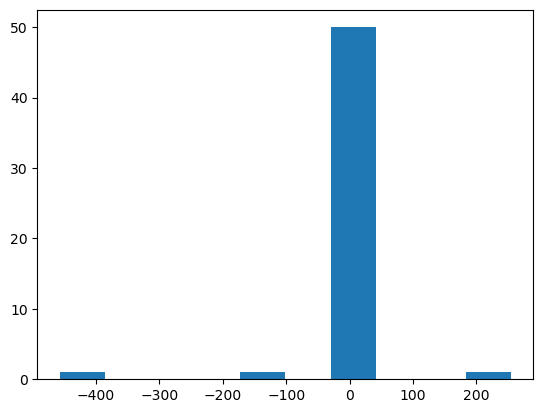

In [29]:
# plot duration uncertainty 
plt.hist(events.duration_diff_mean)
plt.show()

In [30]:
events.to_csv("events_with_duration_unc.csv",sep=',', index=False)